<a href="https://colab.research.google.com/github/iubordei/Ahorcado/blob/master/Practica8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 8. Ejercicio adicional 2:  construyendo un detector de objetos

En este notebook se muestra cómo crear un modelo de detección de objetos usando la arquitectura Faster R-CNN. Para crear nuestro modelo vamos a utilizar la librería [IceVision](https://airctic.com/) que es una librería para crear modelos de detección usando FastAI.

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción Configuración del cuaderno del menú Editar (esta opción debería estar habilitada por defecto, pero es recomendable que lo compruebes).

## Librerías

Comenzamos descargando la librería IceVision. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install icevision[all]==0.5.1
!pip install torchtext==0.8.1

     |████████████████████████████████| 143kB 9.0MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 12.8MB 237kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 58.6MB/s 
     |████████████████████████████████| 194kB 59.0MB/s 
     |████████████████████████████████| 849kB 46.8MB/s 
     |████████████████████████████████| 2.1MB 49.9MB/s 
     |████████████████████████████████| 952kB 48.1MB/s 
     |████████████████████████████████| 37.6MB 75kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 163kB 55.7MB/s 
     |████████████████████████████████| 296kB 58.7MB/s 
     |█

A continuación, cargamos aquellas librerías que son necesarias.

In [2]:
from icevision.all import *

## Dataset

Para esta práctica vamos a usar como ejemplo el [Fruit Images for Object Detection dataset](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection). Este dataset consta de 240 imágenes de entrenamiento y 60 de test con tres categorías: manzanas, plátanos y naranjas. Los siguientes comandos descargan y descomprimen dicho dataset. 

In [3]:
!wget https://www.dropbox.com/s/1dsfd5rrmg3riqj/fruits.zip?dl=1 -O fruits.zip
!unzip fruits.zip

--2021-04-29 21:31:15--  https://www.dropbox.com/s/1dsfd5rrmg3riqj/fruits.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/1dsfd5rrmg3riqj/fruits.zip [following]
--2021-04-29 21:31:15--  https://www.dropbox.com/s/dl/1dsfd5rrmg3riqj/fruits.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1ddfe4062f3ab269b5859a51b.dl.dropboxusercontent.com/cd/0/get/BNhQX9F8ovIhDAtFi9eQIE4yP6-nx8MZPYtMOm9wGpSguB9lBDTPekvq1hisc6C8VtGjrha-3Jmnt2uTPhP-lSwdmGP8ISZO2UFAkO2hfFskCZQ6ongSiBHF2YZuoh2ZRIpyzit29hIiW17jrQGH10Ww/file?dl=1# [following]
--2021-04-29 21:31:15--  https://ucb1ddfe4062f3ab269b5859a51b.dl.dropboxusercontent.com/cd/0/get/BNhQX9F8ovIhDAtFi9eQIE4yP6-nx8MZPYtMOm9wGpSguB9lBDTPekvq1hisc6C8VtGjrha-3Jmnt2uTPhP-lSwdmGP8IS

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto Path que apunta al directorio que acabamos de crear. 

In [4]:
path=Path('fruits')

Podemos ver el contenido de este directorio usando el comando `ls()`.

In [5]:
path.ls()

(#2) [Path('fruits/test'),Path('fruits/train')]

Si exploráis el directorio podréis ver que hay dos carpetas (llamadas train y test), y que cada una de ellas contiene dos carpetas, llamadas images y labels. La carpeta images contiene las imágenes del dataset, y la carpeta labels contiene las anotaciones en formato [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/). Para cada imagen, hay un fichero xml con el mismo nombre que contiene su extensión. 

## Icevision

El proceso para crear y evaluar un modelo de IceVision consta de los siguientes pasos:
1. Crear un parser para leer las imágenes y las anotaciones.
2. Construir objetos record a partir de los parser. 
3. Crear los datasets a partir de los records y los aumentos que queramos aplicar. 
4. Crear un dataloader a partir de los datasets. 
5. Definir un modelo. 
6. Entrenar el modelo. 
7. Guardar el modelo.
8. Usar el modelo para inferencia

Vamos a ver en detalle cada uno de estos pasos. 

### Parser

IceVision proporciona una serie de parsers definidos por defecto para leer las anotaciones en distintos formatos entre ellos Pascal VOC y COCO. También es posible crear parsers propios. A pesar de que existe un parser para el formato de nuestra anotación, vamos a ver cómo crear un parser desde cero. 

Un parser ha de heredar de una serie de clases que proporcionan la funcionalidad que necesitamos. En concreto hemos de definir una clase con la siguiente signatura. 

In [6]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

A continuación IceVision proporciona el método `generate_template` que nos proporciona los métodos que debemos implementar. 

In [7]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


A continuación vamos a implementar nuestra clase con cada uno de esos métodos.

In [8]:
# Cargamos la siguiente librería que nos servirá para leer ficheros XML
import xml.etree.ElementTree as ET

class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    """Definimos el constructor de nuestra clase que va a recibir tres parámetros:
       - El path al directorio donde se encuentran las imágenes.
       - El path al directorio donde se encuentran las anotaciones.
       - Un objeto class_map con las clases que tiene nuestro dataset.
    """
    def __init__(self, path_img,path_anotaciones,class_map):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones
        self.class_map = class_map

    """El método iter escanea el directorio de anotaciones y nos devuelve el nombre 
    de cada fichero. Dicho nombre será utilizado por el resto de método"""    
    def __iter__(self):
        with os.scandir(self.path_anotaciones) as ficheros:
            for fichero in ficheros:
                yield fichero.name
                
    """El método prepare recibe el nombre de un fichero de anotación como parámetro y realiza
    una serie de labores de preprocesamiento sobre dicho fichero de anotación. En este caso lo procesa
    usando la funcionalidad de la librería para trabajar con xml"""
    def prepare(self, o):
        tree = ET.parse(str(self.path_anotaciones)+'/'+str(o))
        self._root = tree.getroot()

    """A partir del nombre del fichero de anotación, imageid debe devolver el identificador
    (o nombre) de la imagen asociada"""
    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
        return o[:o.find('.')]

    """El método filepath a partir del nombre del fichero de anotación devuelve el path de 
    la imagen asociada"""
    def filepath(self, o) -> Union[str, Path]:
        path=Path(f"{o[:o.find('.')]}.jpg")
        return self.path_img / path

    """La función image_width_height devuelve el ancho y el alto de una imagen a partir del nombre
    del fichero de anotación"""
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(str(self.path_img)+'/'+f"{o[:o.find('.')]}.jpg")

    """La función labels recibe el nombre del fichero de anotación y debe devolver una lista 
    con los identificadores de las clases contenidas en dicho fichero."""
    def labels(self, o) -> List[int]:
        labels = []
        for object in self._root.iter("object"):
            label = object.find("name").text
            label_id = self.class_map.get_name(label)
            labels.append(label_id)

        return labels

    """La función bboxes recibe el nombre del fichero de anotación y debe devolver una lista 
    de bboxes que son las anotaciones contenidas en dicho fichero. El formato de cada BBOX es
    xmin, ymin, xmax, ymax."""
    def bboxes(self, o) -> List[BBox]:
        def to_int(x):
            return int(float(x))

        bboxes = []
        for object in self._root.iter("object"):
            xml_bbox = object.find("bndbox")
            xmin = to_int(xml_bbox.find("xmin").text)
            ymin = to_int(xml_bbox.find("ymin").text)
            xmax = to_int(xml_bbox.find("xmax").text)
            ymax = to_int(xml_bbox.find("ymax").text)

            bbox = BBox.from_xyxy(xmin, ymin, xmax, ymax)
            bboxes.append(bbox)

        return bboxes

Una vez que hemos definido nuestra clase para parsear las anotaciones de nuestro dataset, vamos a construir los objetos correspondientes. 

Lo primero que tenemos que hacer es construir nuestro `class_map` que es un objeto de la clase `ClassMap` y que contiene las clases de objetos de nuestro dataset. 

In [9]:
class_map = ClassMap(['apple','banana','orange'])

A continuación definimos nuestros parsers. Uno para leer el conjunto de entrenamiento, y otro para el de test.

In [10]:
trainPath = Path('fruits')/'train'
parserTrain = AnotacionParser(trainPath/'images', trainPath/'labels', class_map)

testPath = Path('fruits')/'test'
parserTest = AnotacionParser(testPath/'images', testPath/'labels', class_map)

### Records

Un record es un diccionario que contiene todos los campos parseados definidos en el proceso anterior. Mientras que cada parser es específico para cada anotación concreta, los objetos record tienen una estructura común. Para construir los records a partir de nuestros objetos `parser` debemos llamar al método `parse` e indicarle cómo se van a repartir los datos que se lean. 

Como siempre, vamos a dividir nuestro dataset en tres partes: un conjunto de entrenamiento, uno de validación y uno de test. Por lo tanto tendremos que construir tres records llamados `train_records`, `valid_records` y `test_records`. Los records de entrenamiento y validación los construiremos a partir de los datos de entrenamiento usando una partición 90/10. Mientras que el record de test se construye a partir del conjunto de test usándolo completamente. 

In [11]:
train_records, valid_records = parserTrain.parse(RandomSplitter((0.9, 0.1)))
test_records,_= parserTest.parse(RandomSplitter((1.0, 0.0)))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


### Transforms

Las transformaciones o aumentos son una parte fundamental cuando estamos construyendo modelos en visión por computador. IceVision incluye por defecto la librería [Albumentations](https://github.com/albumentations-team/albumentations) que nos proporciona una gran cantidad de transformaciones. Además es capaz de gestionar los cambios en la anotación que son necesarios cuando se trabaja en detección de objetos. 

IceVision proporciona una función muy útil que es [`tfms.A.aug_tfms`](https://airctic.com/albumentations_tfms/) con una gran cantidad de transformaciones. Además podemos añadirle cualquier otra transformación de Albumentations. 

Para nuestro ejemplo vamos a usar las transformaciones sugeridas por defecto por IceVision y aplicar la técnica de presizing vista para clasificación de imágenes; además será necesario normalizar las imágenes al rango de las imágenes de ImageNet. Notar que las transformaciones se aplicarán solo al conjunto de entrenamiento. Para los conjuntos de validación y test únicamente tendremos que escalar la imagen al tamaño adecuado y normalizarla. 

In [12]:
presize = 512
size = 384

In [13]:
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

### Dataset

La clase `Dataset` sirve para combinar los records y las transformaciones. Debemos crear un dataset para nuestro conjunto de entrenamiento, otro para el conjunto de validación y otro para el de test.

In [14]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
test_ds = Dataset(test_records, valid_tfms)

Una vez creados dichos datasets podemos mostrar imágenes de los mismos. En concreto la siguiente instrucción muestra imágenes del conjunto de entrenamiento a las cuáles se les han aplicado una serie de transformaciones. Es conveniente ejecutar esta visualización para comprobar que todo está correcto. 

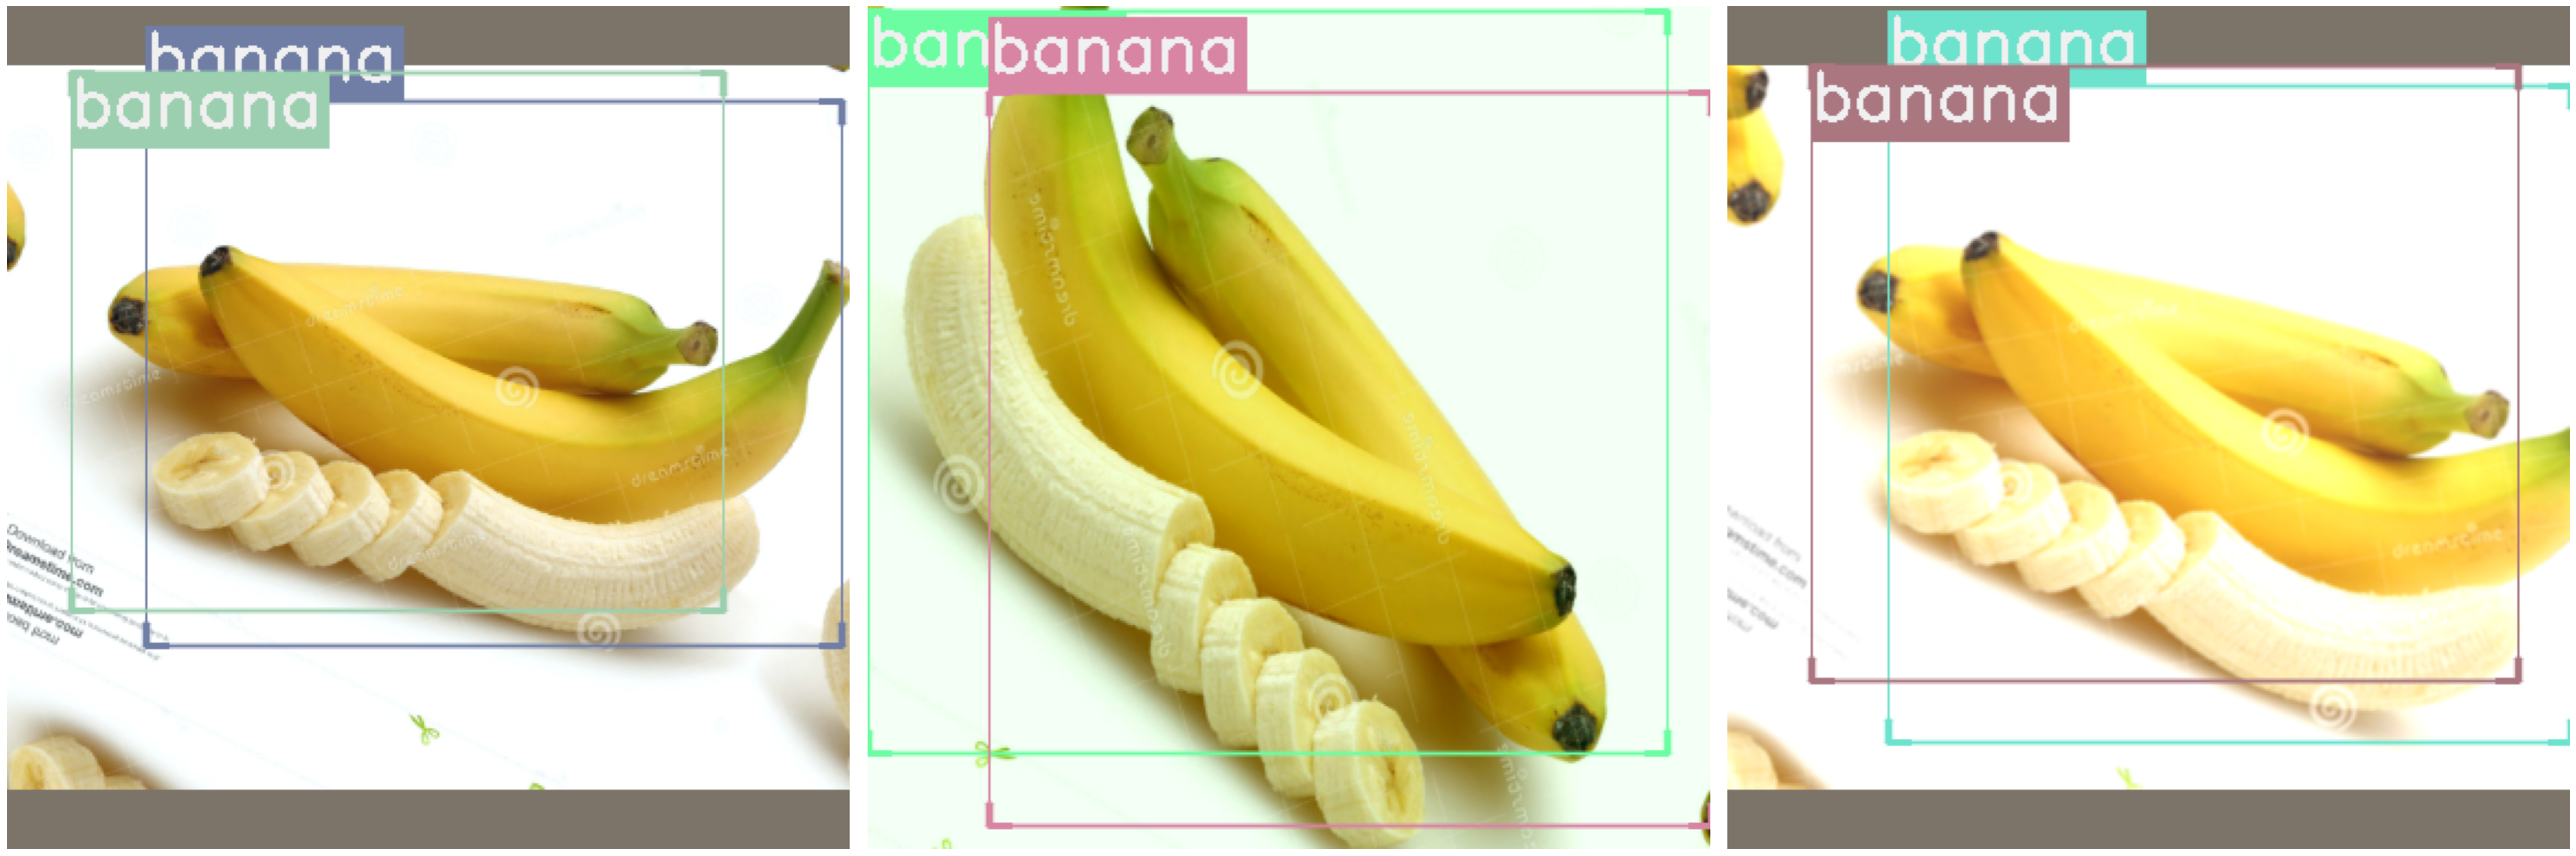

In [15]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

### DataLoaders

El último paso es crear nuestros DataLoaders a partir de los datasets construidos anteriormente. Notar que cada modelo tiene su propio DataLoader. En este caso como vamos a crear un modelo de Faster RCNN debemos usar las siguientes instrucciones. 

In [16]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=8, num_workers=0, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=8, num_workers=0, shuffle=False)
test_dl = faster_rcnn.valid_dl(test_ds, batch_size=8, num_workers=0, shuffle=False)

### Entrenando el modelo

Para crear y entrenar nuestro modelo debemos crear un objeto `Learner` de FastAI. Para crear dicho objeto, lo primero que debemos hacer es construir un modelo con la arquitectura que queremos usar, en este caso Faster RCNN. 

In [17]:
model = faster_rcnn.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

A continuación debemos proporcionar las métricas que queremos utilizar para evaluar el modelo. Por el momento la única métrica soportada por IceVision es el mAP de COCO, por lo tanto utilizaremos dicha métrica.

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

Ya estamos listos para construir nuestro `Learner`. Notar que dicho objeto se construye de manera distinta dependiendo de la arquitectura que queramos utilizar. 

In [19]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

Ahora podemos entrenar nuestro modelo utilizando la técnica de fine tuning. 

In [20]:
learn.fine_tune(10,freeze_epochs=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.458200,0.378386,0.228447,00:13
1,0.371141,0.330479,0.287319,00:12


epoch,train_loss,valid_loss,COCOMetric,time
0,0.259634,0.263792,0.491203,00:23
1,0.256721,0.303766,0.441140,00:21
2,0.261976,0.305375,0.422934,00:21
3,0.253400,0.284838,0.392178,00:22
4,0.247830,0.258452,0.500198,00:22
5,0.235575,0.222283,0.491647,00:22
6,0.220471,0.220855,0.585809,00:22
7,0.210146,0.227088,0.535777,00:22
8,0.197721,0.224606,0.629531,00:22
9,0.188987,0.222598,0.608771,00:22


Una vez finalizado el entrenamiento podemos guardar nuestro modelo del siguiente modo. 

In [21]:
torch.save(model.state_dict(),'fasterRCNNFruits.pth')

### Evaluando el modelo

Al igual que vimos para los modelos de clasificación, la métrica mostrada durante el proceso de entrenamiento se refiere al conjunto de validación, mientras que nos interesa saber el resultado obtenido para el conjunto de test. 

Para ello, lo primero que debemos hacer es construir un nuevo dataloader del siguiente modo, indicando que el conjunto de validación es el de test. 

In [22]:
newdl = fastai.DataLoaders(faster_rcnn.fastai.convert_dataloader_to_fastai(train_dl),faster_rcnn.fastai.convert_dataloader_to_fastai(test_dl)).to('cuda')

A continuación modificamos el dataloader del objeto `Learn` que hemos entrenado anteriormente.

In [23]:
learn.dls = newdl

Por último evaluamos nuestro modelo usando el método `validate()`. El método `validate()` devuelve dos valores, el valor de la pérdida y el valor de la métrica asociada al conjunto de validación, que en este caso es el de test. 

In [24]:
learn.validate()

(#2) [0.22387325763702393,0.5868396803736492]

### Inferencia

Vamos a ver cómo usar el modelo ante una nueva imagen. Para ello lo primero que vamos a hacer es cargar dicho modelo. Para ello debemos crear un modelo con la arquitectura que utilizamos (Faster RCNN en nuestro caso), y posteriormente cargar el modelo. 

In [25]:
model = faster_rcnn.model(num_classes=len(class_map))
state_dict = torch.load('fasterRCNNFruits.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

El siguiente paso es cargar la imagen, para lo que usaremos la librería `PIL`.

In [26]:
import PIL

In [27]:
img = np.array(PIL.Image.open('fruits/test/images/mixed_25.jpg'))

La siguiente instrucción permite mostrar la imagen que acabamos de cargar. 

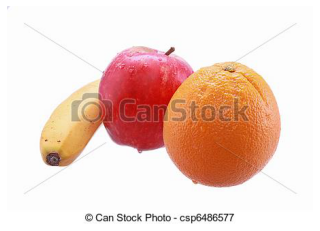

In [28]:
show_img(img);

Ya estaríamos listos para relizar las predicciones sobre la imagen. Sin embargo, cabe recordar que primero debemos reescalar las imágenes y normalizarlas.

In [29]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size),tfms.A.Normalize()])

El siguiente paso es crear un dataset (podemos cargar varias imágenes en el mismo).

In [30]:
infer_ds = Dataset.from_images([img], infer_tfms)

Y por último realizamos las predicciones llamando a `build_infer_batch` y a continuación a `predict` (notar que estos métodos son dependientes de la arquirectura que hayamos utilizado). Notar también que en el método `predict` podemos fijar el nivel de confianza mínimo para realizar la predicción.

In [31]:
batch, samples = faster_rcnn.build_infer_batch(infer_ds)
preds = faster_rcnn.predict(model=model, batch=batch,detection_threshold=0.5)

Por último podemos mostrar las predicciones que se han realizado del siguiente modo.

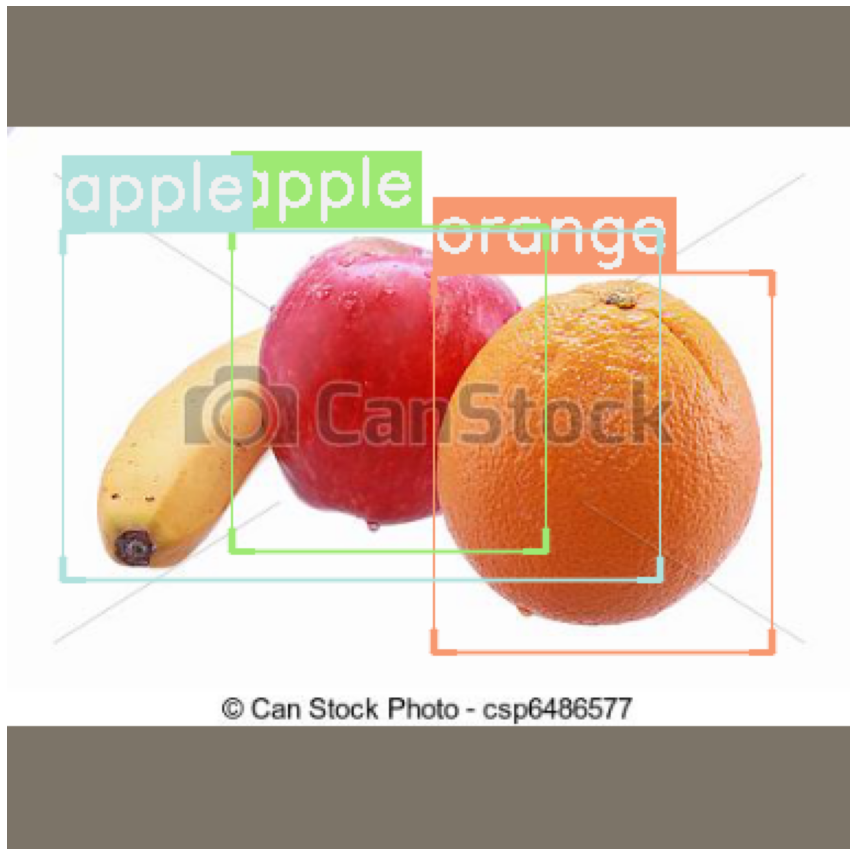

In [32]:
imgs = [sample["img"] for sample in samples]
show_preds(
    samples=imgs,
    preds=preds,
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    show=True,
)

## Ejercicio 

A continuación se listan una serie de datasets que están disponibles en Kaggle o en otras fuentes. El ejercicio que tenéis que realizar consiste en elegir uno de esos datasets (también podéis elegir otro que vosotros prefiráis) y construir un modelo siguiendo las instrucciones proporcionadas a lo largo de este notebook. 

- [Kangaroo dataset](https://github.com/experiencor/kangaroo).
- [Racoon dataset](https://github.com/datitran/raccoon_dataset).
- [Wheat detection](https://www.kaggle.com/c/global-wheat-detection/data).
- [Winegrape Detection Dataset](https://github.com/thsant/wgisd). 

También puedes elegir cualquiera de los datasets disponibles en [50+ Object Detection Datasets from different industry domains](https://towardsai.net/p/computer-vision/50-object-detection-datasets-from-different-industry-domains) o utilizar un dataset de otra fuente. **Ojo.** Cuidado con el tamaño de los datasets, si contienen muchas imágenes el proceso de entrenamiento puede ser muy largo. 

In [34]:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 41.84 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [36]:
path=Path('kangaroo')
path.ls()

(#4) [Path('kangaroo/annots'),Path('kangaroo/.git'),Path('kangaroo/README.md'),Path('kangaroo/images')]

In [37]:
class_map = ClassMap(['kangaroo'])

In [38]:
kangarooPath = Path('kangaroo')
parserTrain = AnotacionParser(kangarooPath/'images', kangarooPath/'annots', class_map)

In [42]:
from sklearn.model_selection import train_test_split
train_records, test_records = parserTrain.parse(RandomSplitter((0.9, 0.3)))
train_records, valid_records = train_test_split(train_records, test_size=0.1, random_state=42)

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [44]:
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
test_ds = Dataset(test_records, valid_tfms)

IndexError: ignored

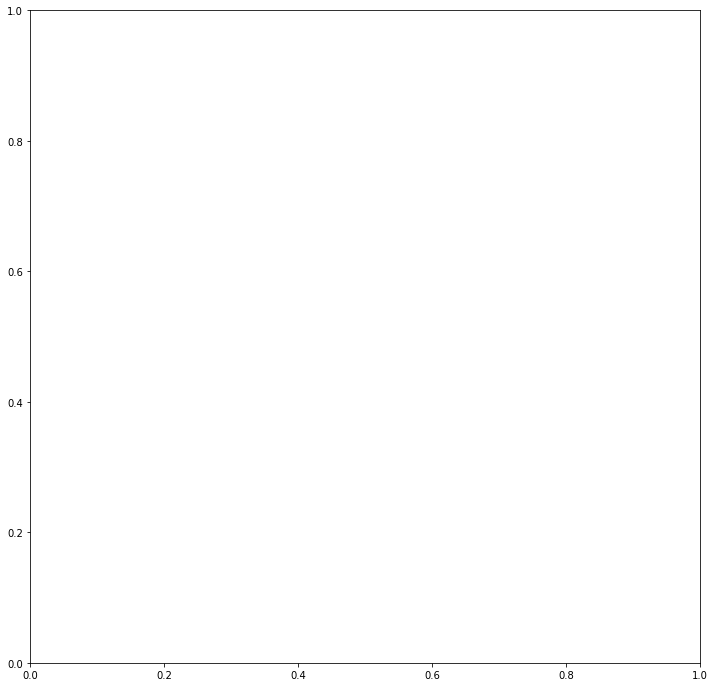

In [50]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)